<a href="https://colab.research.google.com/github/Nareshedagotti/RAG/blob/main/Day_4_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Day4 - How Vectors Are Stored, Indexed, and Retrieved**

**Introduction**

How text is converted into vectors, stored in a database, indexed efficiently, and used to retrieve similar information — with code & real-world examples.

### **Text to Vector – Embedding**

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')
texts = [
    "Apples are sweet and red.",
    "Bananas are yellow and soft.",
    "Kids love mangoes during summer."
]
embeddings = model.encode(texts)

#### **Behind the Scenes:**
**When model.encode() runs, it:**

1. Tokenizes text → converts to word pieces (subwords like "embed" + "##ding")
2. Feeds tokens through transformer layers with attention mechanisms
3. Pools token representations to create a single vector
4. Outputs a vector (384 dimensions) representing semantic meaning


#### **Output Example:**

In [ ]:
print(embeddings[0][:5])  # First 5 values of first embedding
# [0.1213, 0.3421, -0.5632, 0.1834, 0.0507]

print(embeddings.shape)
# (3, 384) - 3 texts, each with 384-dimensional vectors

### **How Embeddings Are Stored in a Vector Database**

#### **Conceptual View (For Understanding):**

| Chunk ID | Text Chunk         | Vector (Embedding)       | Metadata    |
|----------|--------------------|--------------------------|-------------|
| text1    | "Apples are red."  | [0.12, 0.34, -0.22, ...] | page: "1"   |
| text2    | "Bananas are yellow." | [0.41, -0.18, 0.65, ...] | page: "2"   |
| text3    | "Kids love mangoes." | [0.22, 0.17, -0.34, ...] | page: "3"   |

**Note:** This looks like a table, but vector databases use specialized data structures.

#### **Actual Storage Inside Vector DB:**

In [ ]:
# Example using Chroma
import chromadb

client = chromadb.Client()
collection = client.create_collection("fruit_facts")

collection.add(
    ids=["doc1", "doc2", "doc3"],
    embeddings=[
        [0.12, 0.34, -0.22],  # Simplified for demo (really 384-dim)
        [0.41, -0.18, 0.65],
        [0.22, 0.17, -0.34]
    ],
    metadatas=[
        {"text": "Apples are red", "page": 1},
        {"text": "Bananas are yellow", "page": 2},
        {"text": "Kids love mangoes", "page": 3}
    ]
)

#### **What's Happening Under the Hood:**

In [ ]:
# Pseudocode for what's happening internally
vector_index["text1"] = [0.12, 0.34, -0.22, ...]   # Goes to optimized vector index
metadata_store["text1"] = {                        # Goes to metadata store
    "text": "Apples are red",
    "page": 1
}

1.Vectors are stored in specialized data structures optimized for similarity search:
* HNSW (Hierarchical Navigable Small World) - graph-based index
* IVF (Inverted File) - clustering-based index
* Flat - brute force comparison (simple but slow)

2.Metadata is stored separately in a key-value store or document DB

3.IDs link the vector index with the metadata store


## **Vector Database Indexing**

### **Indexing in Vector Databases**

**What is Indexing in VectorDBs?**

Indexing is a fundamental technique used to organize vector data for efficient similarity search operations. In the context of vector databases, indexing creates specialized data structures that make nearest neighbor search operations faster and more efficient, especially when dealing with high-dimensional embeddings from text, images, audio, or other data types.

**Why Indexing Matters**

Raw vector comparison (brute force) becomes prohibitively slow as datasets grow
Dimensionality curse makes searching in high-dimensional spaces challenging
Properly indexed data can deliver results orders of magnitude faster
Enables practical applications of vector search in production environments

**Two Major Categories of Indexing**

1.Exact Indexing
* Guarantees 100% accurate results
* Generally slower but provides perfect recall

Example: Flat (brute-force) index

2.Approximate Indexing (ANN - Approximate Nearest Neighbors)
* Trades a small amount of accuracy for significant speed gains
* Uses various techniques to efficiently narrow down the search space

Examples: IVF, HNSW, PQ, ANNOY

**Distance Metrics in Vector Search**

The choice of distance metric is critical in vector search:

**Euclidean Distance (L2):** Measures straight-line distance between vectors

**Cosine Similarity:** Measures the cosine of the angle between vectors (similarity of orientation)

**Dot Product:** Inner product between vectors (works well with normalized vectors)

**Manhattan Distance (L1):** Sum of absolute differences between vectors

**Hamming Distance:** For binary vectors, counts positions where bits differ


### **1.Flat (Brute-Force) Index**

**What is the Flat Index?**

A flat index is the simplest indexing method that performs an exhaustive search by comparing the query vector with every vector in the database.

**When to Use Flat Index**

* Small to medium datasets (typically ≤100K vectors)
* When 100% accuracy is critical (e.g., security applications, financial matching)
* During development and testing to establish baseline performance
* When the dimensionality of vectors is relatively low

**How Flat Index Works**

* No preprocessing or clustering is performed
* All vectors are stored in their original form
* Each query requires direct distance computation with every stored vector
* Typically uses Euclidean (L2) distance or cosine similarity

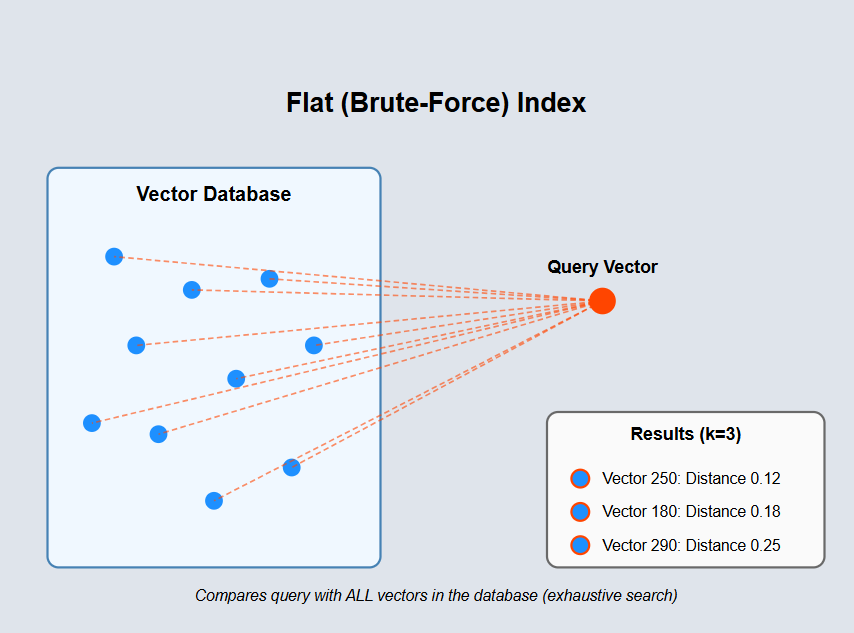


##### **Implementation Example (FAISS)**

In [ ]:
import faiss
import numpy as np

# Create sample data
dimension = 128
num_vectors = 10000
vectors = np.random.random((num_vectors, dimension)).astype('float32')

# Create a flat index with L2 distance
index_flat_l2 = faiss.IndexFlatL2(dimension)
# For cosine similarity, normalize vectors and use dot product
index_flat_ip = faiss.IndexFlatIP(dimension)  # IP = Inner Product

# Add vectors to the index
index_flat_l2.add(vectors)

# Search
k = 5  # Number of nearest neighbors to retrieve
query = np.random.random((1, dimension)).astype('float32')
distances, indices = index_flat_l2.search(query, k)

**Advantages**

* Simple implementation requiring no training phase

* 100% accurate results (exact nearest neighbors)
* Works with any distance metric
* No hyperparameters to tune

**Disadvantages**
* Search time grows linearly with dataset size (O(n) complexity)
* Memory intensive as all vectors must be stored in full precision
* Becomes impractical for large datasets


### **2.Inverted File Index (IVF)**

**What is IVF?**

IVF organizes vectors into clusters (using algorithms like k-means) and narrows search to only the most relevant clusters, dramatically speeding up search on large datasets.

**When to Use IVF**

* Medium to large datasets (1M+ vectors)
* When you need a balance between speed and accuracy
* When you can accept approximate results (small accuracy trade-off)
* When you have a representative sample for training

**How IVF Works**
* Training phase: Vectors are clustered into nlist clusters (centroids)
* Assignment phase: Each vector is assigned to its nearest centroid

**Search phase:**
* Query vector is compared to all centroids
* Only vectors in the nprobe nearest clusters are examined
* nprobe is a tunable parameter that balances speed vs. accuracy

**Distance Metrics**
* Uses the same distance metrics as flat indexes (typically L2 or cosine)
* The choice affects both clustering and search phases

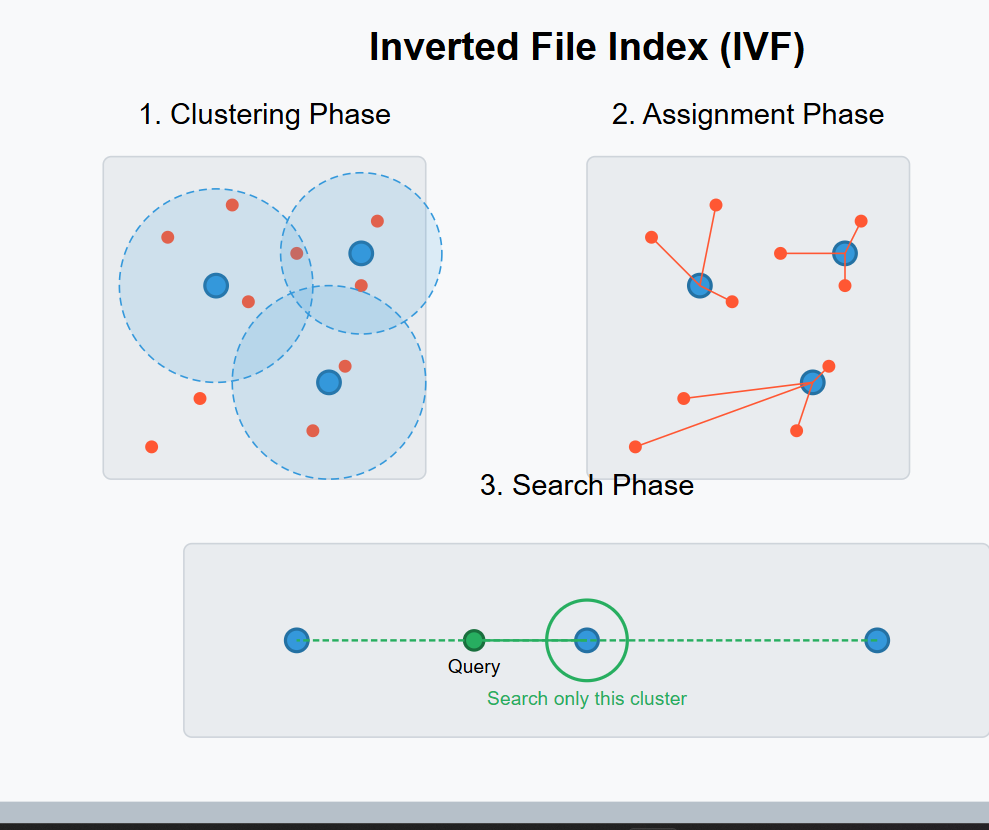


#### **Implementation Example (FAISS)**

In [ ]:
import faiss
import numpy as np

dimension = 128
num_vectors = 1000000
vectors = np.random.random((num_vectors, dimension)).astype('float32')

# Create quantizer (the index for centroids)
quantizer = faiss.IndexFlatL2(dimension)

# Create the IVF index
nlist = 100  # Number of clusters
index_ivf = faiss.IndexIVFFlat(quantizer, dimension, nlist, faiss.METRIC_L2)

# Must train the index with representative data
index_ivf.train(vectors[:100000])  # Can use subset for training
index_ivf.add(vectors)

# Set search parameters
index_ivf.nprobe = 10  # Number of clusters to visit during search

### **3.Product Quantization (PQ)**

**What is Product Quantization?**

PQ is a compression technique that reduces the memory footprint of vectors by encoding them into compact codes, making it possible to store and search billions of vectors efficiently.

**When to Use PQ**

* Very large datasets (10M+ vectors)
* Memory-constrained environments
* When speed and memory efficiency are more important than perfect accuracy
* Often combined with IVF for better performance (IVF-PQ)

**How PQ Works**
* Vector splitting: Each vector is divided into M equal sub-vectors
* Codebook generation: For each sub-vector space, k-means clustering creates a codebook
* Quantization: Each sub-vector is replaced by its nearest centroid's index
* Storage: Instead of storing the full vector, only centroid indices are stored
* Distance approximation: Distances are computed using pre-computed lookup tables

**Distance Considerations with PQ**
* PQ works best with Euclidean (L2) distance
* For cosine similarity, vectors should be normalized before quantization
* Distance computations are approximated, affecting accuracy

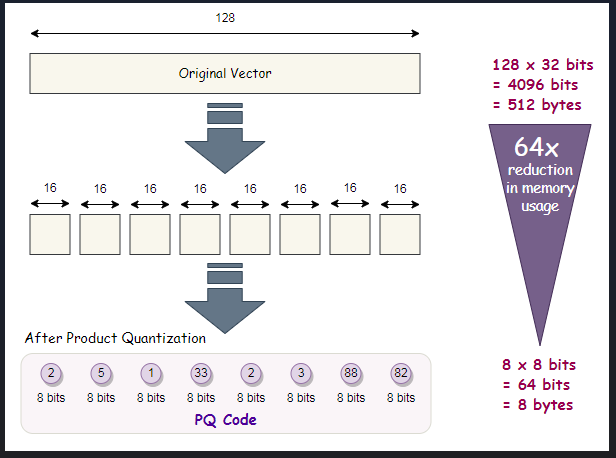

#### **Implementation Example (FAISS)**

In [ ]:
import faiss
import numpy as np

dimension = 128
num_vectors = 10000000
vectors = np.random.random((num_vectors, dimension)).astype('float32')

# Create quantizer
quantizer = faiss.IndexFlatL2(dimension)

# Create an IVF-PQ index
nlist = 1000  # Number of clusters
m = 8         # Number of subquantizers
nbits = 8     # Bits per subquantizer (256 centroids per subquantizer)
index_ivfpq = faiss.IndexIVFPQ(quantizer, dimension, nlist, m, nbits)

# Train and add vectors
index_ivfpq.train(vectors[:100000])
index_ivfpq.add(vectors)

# Set search parameters
index_ivfpq.nprobe = 20  # Number of clusters to search

**Tuning PQ Parameters**

* m (number of subquantizers): Higher values = better accuracy but larger codes
* nbits (bits per subquantizer): Usually 8 (256 centroids per subquantizer)
* nlist and nprobe: Same as in IVF

**Advantages**
* Extremely memory efficient (can reduce memory by 10-100x)
* Enables searching billions of vectors on standard hardware
* Fast distance computations using lookup tables

**Disadvantages**
* Lower accuracy compared to flat or IVF indexes
* Complex setup with multiple hyperparameters
* Performance highly dependent on data characteristics

### **4.Graph-based Indexing (HNSW)**

**What is HNSW?**

Hierarchical Navigable Small World (HNSW) is a graph-based indexing method that creates a multi-layered graph structure for efficient navigation to nearest neighbors.

**When to Use HNSW**

* Medium to large datasets where search speed is critical
* Real-time applications requiring low latency
* When high accuracy is important, but you can't use flat index
* When you have sufficient memory to store the graph structure

**How HNSW Works**

1.Graph construction: Each vector becomes a node connected to its neighbors

2.Hierarchical structure: Multiple layers with varying connection densities

3.Search process:
* Start at entry point in the top layer
* Greedily move to closer neighbors
* Descend through layers, refining the search
* Stop at the bottom layer with the best candidates

**Distance Metrics in HNSW**
* Works with any distance metric (L2, cosine, etc.)
* Distance calculations are exact, but search path is approximate
* The choice of metric affects both graph construction and search

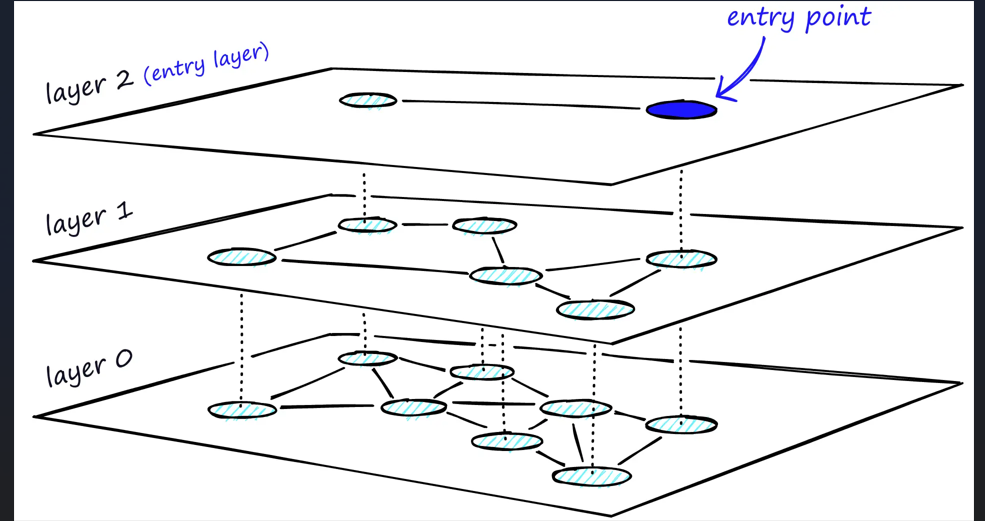

#### **Implementation Example (FAISS)**

In [ ]:
import faiss
import numpy as np

dimension = 128
num_vectors = 1000000
vectors = np.random.random((num_vectors, dimension)).astype('float32')

# Create HNSW index
M = 16    # Number of connections per layer
efC = 100  # Construction-time exploration factor
index_hnsw = faiss.IndexHNSWFlat(dimension, M)
index_hnsw.hnsw.efConstruction = efC
index_hnsw.hnsw.efSearch = 64  # Search-time exploration factor

# Add vectors (no separate training needed)
index_hnsw.add(vectors)

**Tuning HNSW Parameters**

M (connections per node): Higher values = better accuracy but more memory
* Typical values: 16-64

efConstruction (build-time accuracy): Higher values = better index quality but slower build
* Typical values: 100-500

efSearch (search-time accuracy): Higher values = better search accuracy but slower search
* Can be adjusted at query time

**Advantages**
* Excellent balance of speed and accuracy
* No training phase required
* Dynamic updates possible (can add vectors after construction)
* Works well with filtered queries

**Disadvantages**
* Memory intensive (stores both vectors and graph links)
* Index construction can be slow
* More complex implementation than other methods


### **5.Scalar Quantization (SQ)**

**What is Scalar Quantization?**

Scalar Quantization reduces the precision of vector components (e.g., from 32-bit float to 8-bit integer) to decrease memory usage while maintaining reasonable accuracy.

**When to Use SQ**
* When you need moderate memory savings with minimal accuracy loss
* As a simpler alternative to PQ when extreme compression isn't needed
* Can be combined with other index types (Flat-SQ, IVF-SQ, etc.)

**How SQ Works**
* Determine the range of values in each dimension
* Map these ranges to fixed-bit representations (typically 8-bit)
* Convert each floating-point value to its quantized form

**Distance Considerations**
* Works with both L2 distance and inner product (cosine similarity)
* Slightly reduced accuracy due to quantization error
* Computations may be faster due to integer arithmetic

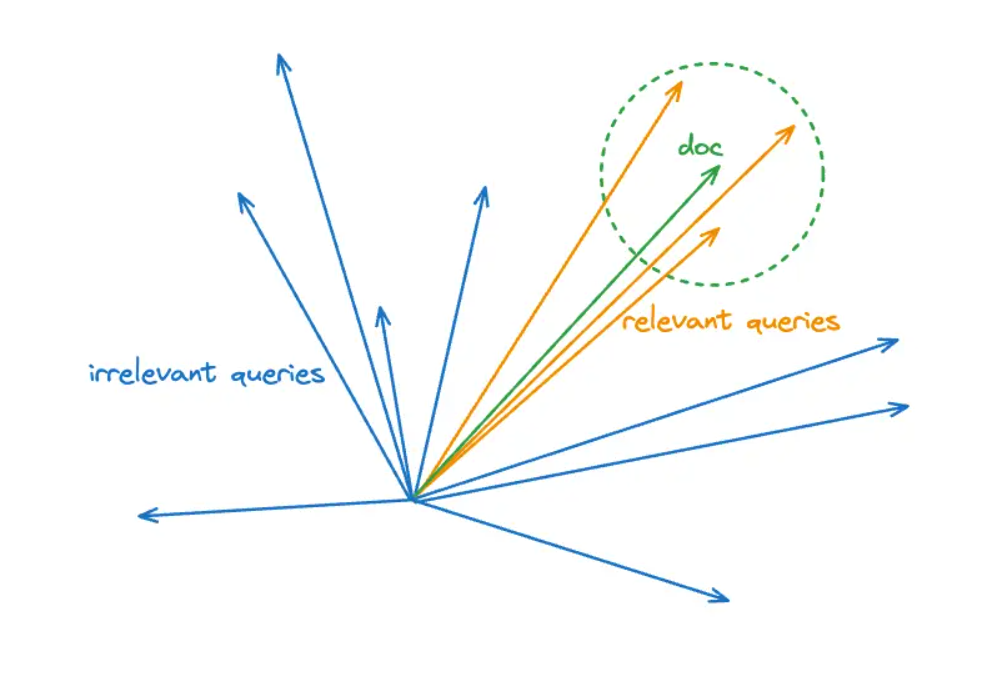


####**Implementation Example (FAISS)**

In [ ]:
import faiss
import numpy as np

dimension = 128
num_vectors = 1000000
vectors = np.random.random((num_vectors, dimension)).astype('float32')

# Create Scalar Quantized index
index_sq = faiss.IndexScalarQuantizer(dimension, faiss.ScalarQuantizer.QT_8bit, faiss.METRIC_L2)
# Alternative: combine with IVF
quantizer = faiss.IndexFlatL2(dimension)
index_ivfsq = faiss.IndexIVFScalarQuantizer(quantizer, dimension, 1000,
                                           faiss.ScalarQuantizer.QT_8bit, faiss.METRIC_L2)

# Train and add vectors
index_ivfsq.train(vectors[:100000])
index_ivfsq.add(vectors)

**Advantages**
* Simple implementation and concept
* Moderate memory savings (4x compared to 32-bit floats)
* Minimal accuracy impact

**Disadvantages**
* Less compression than PQ
* Still requires significant memory for large datasets


### **VectorDB Specific Indexing Features**

#### **Major Vector Database Comparison — Special Features by Database**

#### **FAISS**
- Supports **GPU acceleration** for both indexing and search  
- Provides **multi-GPU and distributed search** capabilities

---

#### **Vector Database Overview**

| **Vector Database** | **Supported Index Types** | **Distance Metrics** | **Auto-Indexing?** | **Key Features** |
|---------------------|---------------------------|-----------------------|---------------------|------------------|
| **FAISS**           | Flat, IVF, PQ, HNSW, SQ, LSH, combinations | L2, Cosine, Dot Product | ❌ | Highly customizable, GPU support |
| **Pinecone**        | Proprietary (HNSW-based) | Cosine, Dot Product, Euclidean | ✅ | Fully managed, serverless, auto-scaling |
| **Weaviate**        | HNSW, Flat | Cosine | ✅ | Schema-based, multi-modal, GraphQL API |
| **Qdrant**          | HNSW, Scalar Quantization | Cosine, Dot Product, Euclidean | ✅ | Strong filtering, payload storage |
| **Milvus**          | IVF, HNSW, PQ, ANNOY, combinations | Euclidean, IP, Jaccard, others | ✅ | Hybrid search, cloud/self-hosted |
| **Chroma**          | HNSW | Cosine, L2, IP | ✅ | Simple API, embedding function integration |
| **Elasticsearch**   | HNSW | Cosine, Dot Product, L2 | ✅ | Text+vector search, mature ecosystem |
| **pgvector**        | IVF, HNSW | Cosine, L2, IP | ✅ | Postgres extension, familiar SQL interface |

---

#### **Special Capabilities**

- **FAISS**: Allows custom combination of index types (e.g., IVF + PQ + SQ)
- **Pinecone**:
  - Automatic index selection and optimization  
  - Namespace support for logical data separation  
  - Handles pod-based scaling for high throughput  
- **Weaviate**:
  - Modular architecture with multi-modal search  
  - Contextionization for dynamic vector generation  
  - BM25/TF-IDF hybrid search with vector search  
- **Qdrant**:
  - Advanced payload filtering with vector search  
  - Payload-based negative filtering for search results  
  - Optimized disk storage with memory-mapped files  
- **Milvus**:
  - Dynamic schema changes without reindexing  
  - Scalar, vector, and hybrid search capabilities  
  - Time travel queries (historical data access)  

---

#### **Choosing the Right Index — Decision Framework**

| **Question** | **Use Case Example** | **Recommended Index** | **Distance Metric** |
|--------------|-----------------------|------------------------|----------------------|
| Do you need 100% accuracy? | Financial transaction matching | Flat Index | Typically L2 or Cosine |
| Do you have millions of vectors? | Large-scale semantic search | IVF or HNSW | Cosine for text, L2 for images |
| Is speed more important than accuracy? | Real-time product recommendations | HNSW | Cosine similarity |
| Are you on low memory hardware? | Mobile or embedded search | IVF-PQ or SQ | L2 often preferred |
| Do you need incremental updates? | Dynamic document database | HNSW | Any, depending on data |
| Is your data high-dimensional (500+)? | Large language model embeddings | PQ + IVF | Cosine similarity |

---

#### **Dataset Size Recommendations**

| **Dataset Size** | **First Choice** | **Alternative** | **Notes** |
|------------------|------------------|------------------|-----------|
| < 100K vectors | Flat | HNSW | Flat for simplicity, HNSW if query speed critical |
| 100K - 1M vectors | HNSW | IVF | HNSW for better accuracy-speed tradeoff |
| 1M - 10M vectors | IVF-HNSW | IVF | Combined approach for balanced performance |
| 10M - 100M vectors | IVF-PQ | IVF-SQ | Compression becomes necessary |
| > 100M vectors | IVF-PQ | Distributed HNSW | Must consider distribution or extreme compression |


### **Creating Advanced Indices for Faster Retrieval**

In [ ]:
# Create an HNSW index (much faster for large datasets)
nlist = 1     # Number of clusters (use higher for millions of vectors)
M = 16        # Number of connections per layer (higher = more accurate, slower)
ef_construction = 200  # Controls index quality

index_hnsw = faiss.IndexHNSWFlat(d, M)
index_hnsw.hnsw.efConstruction = ef_construction
index_hnsw.add(embeddings_np)

**Behind the Scenes of HNSW:**

Hierarchical Navigable Small World creates a multi-layer graph
Each vector connects to M most similar vectors
Creates "shortcuts" through vector space

**During construction:**

Insert vector at top layer
Navigate down through layers using greedy search
Connect to nearest neighbors at each layer
Maintain max connections per node (M)

**Visualization:**

Layer 2:  •───•
  
          │   

Layer 1:  •───•───•
        
          │   │   │

Layer 0:  •───•───•───•───•───•
         
          All vectors in bottom layer


### **Retrieving Similar Chunks**

In [ ]:
# Create a query vector
query_text = "Which fruit is red?"
query_vector = model.encode([query_text])[0].astype('float32')

# Search the index
k = 2  # Return top 2 results
distances, indices = index.search(np.array([query_vector]).astype('float32'), k)

# Display results
print(f"Top {k} matches for '{query_text}':")
for i, (dist, idx) in enumerate(zip(distances[0], indices[0])):
    print(f"{i+1}. Text: '{texts[idx]}' (Distance: {dist:.4f})")

**Behind the Scenes:**

Query text is converted to a vector using same model

**Vector DB performs distance calculations:**
* For Flat index: Computes distance to EVERY vector (O(n))
* For HNSW index: Traverses graph structure (O(log n))
* Returns indices of closest vectors and their distances


### **How Similarity is Calculated**
Different similarity metrics can be used, affecting how "closeness" is measured:


**Euclidean Distance (L2):**

In [ ]:
# Already used in our FAISS example
index = faiss.IndexFlatL2(d)  # Lower value = more similar

**Cosine Similarity:**

In [ ]:
# Normalize vectors for cosine similarity
faiss.normalize_L2(embeddings_np)  # In-place normalization

# Create index that measures inner product (dot product)
index_ip = faiss.IndexFlatIP(d)    # Higher value = more similar
index_ip.add(embeddings_np)        # Add normalized vectors

# Normalize query for search
query_vector_norm = query_vector.copy()
faiss.normalize_L2(np.array([query_vector_norm]).astype('float32'))

**Mathematical Understanding:**

Euclidean: Straight-line distance between points in vector space

Formula: sqrt(sum((a_i - b_i)²))

Cosine: Angle between vectors (ignores magnitude)

Formula: dot(a, b) / (||a|| * ||b||)

After normalization, dot product = cosine similarity


### **Real-World Use Case: Building a Simple Q&A System**
**Complete Working Example:**

In [ ]:
import numpy as np
from sentence_transformers import SentenceTransformer
import faiss

# 1. Create a knowledge base
documents = [
    "Apples are red or green fruits that grow on trees.",
    "Bananas are yellow fruits with a soft texture inside.",
    "Oranges are citrus fruits known for vitamin C content.",
    "Strawberries are red berries with seeds on the outside.",
    "Blueberries are small blue fruits rich in antioxidants."
]

# 2. Convert to embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
document_embeddings = model.encode(documents).astype('float32')

# 3. Create and populate index
dimension = document_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(document_embeddings)

# 4. Function to answer questions
def answer_question(question, index, documents, model, k=2):
    # Convert question to vector
    query_vector = model.encode([question]).astype('float32')

    # Search
    distances, indices = index.search(query_vector, k)

    print(f"Question: {question}\n")
    print("Top relevant information:")
    for i, (idx, dist) in enumerate(zip(indices[0], distances[0])):
        print(f"{i+1}. {documents[idx]} (Distance: {dist:.4f})")

    print("\n---\n")

# 5. Try it out
questions = [
    "What color are apples?"
]

for question in questions:
    answer_question(question, index, documents, model)

### **Real-Life Analogy: Vector Databases**

Vector databases are like **Google Maps for ideas**:

- **Vector space** is like a vast **landscape of meaning**  
- **Embedding model** acts as a **coordinate system**
- **Indexing** creates **highways and shortcuts** for faster travel  
- **Query** is your **starting point**
- **Similarity search** finds the closest **"locations" in meaning-space**


#### **Applications**

- Semantic search engines  
- Chatbot memory & knowledge retrieval  
- Recommendation systems  
- Content discovery  
- Document deduplication  


#### **Summary: Step-by-Step Workflow**

| **Step**      | **Description**           | **Code Example**                | **What Happens** |
|---------------|---------------------------|----------------------------------|------------------|
| **1. Embedding** | Convert text to vectors    | `model.encode(texts)`           | Neural network transforms text to numerical representation |
| **2. Storage**   | Save vectors in DB         | `collection.add(...)`           | Vectors stored in specialized structures + metadata in KV store |
| **3. Indexing**  | Build efficient search structure | `faiss.IndexHNSWFlat(d, M)` | Creates graph or clusters for fast navigation |
| **4. Query**     | Convert question to vector | `model.encode([query])`         | Same process as original text |
| **5. Retrieval** | Find similar vectors       | `index.search(query_vector, k)` | Finds nearest neighbors using distance metric |


> **Key Insight:**  
Vector databases bridge the gap between **human language** and **machine understanding**, enabling **semantic search** beyond keyword matching.
